In [2]:
import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME', force_remount=True)
    #predir='/content/ME/My Drive/'
    predir='/content/ME/MyDrive/Machine_learning/'
else:
    predir = os.path.join('Users','amit','Google Drive')
    if os.path.isdir(os.path.join(predir,'My Drive')):
            predir=os.path.join(predir,'My Drive')
   
import torch
import numpy as np

# Torch functions 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
datadir=predir
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at ME


### Get Mnist data and split into train validation and test

In [3]:
def get_mnist():

    
    data=np.float64(np.load(datadir+'MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:55000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

### Get cifar10 data and split into training, validation and testing.

In [4]:
import h5py

def get_cifar():
    with h5py.File(datadir+'cifar10_train.hdf5', "r") as f:
        tr=f[('data')][:].transpose(0,3,1,2)
        tr_lb=f[('labels')][:]
    train_data=np.float32(tr[0:45000])/255.
    train_labels=tr_lb[0:45000]
    val_data=np.float32(tr[45000:])/255.
    val_labels=tr_lb[45000:]
    
    with h5py.File(datadir+'cifar10_test.hdf5', "r") as f:
        test_data=f[('data')][:].transpose(0,3,1,2)
        test_data=np.float32(test_data)/255.
        test_labels=f[('labels')][:]
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)


### Get the data 

In [5]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="cifar"):
        return(get_cifar())

### The network

In [7]:
class MNIST_Net(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        

# Run one epoch

In [8]:
def run_epoch(net,epoch,train,pars,num=None,ttype="train"):
    
    
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0

        for j in trange(0,n,pars.batch_size):
                
                # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
                data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)
                targ=torch.torch.from_numpy(y[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                
                # Implement SGD step on batch
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                

        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))
    return train_loss, train_correct / len(y)

In [9]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),pars.batch_size):
                    data=torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
                    targ = torch.from_numpy(yval[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))
    return test_loss, test_correct / len(yval)

# Run the training. Save the model and test at the end

In [10]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=2
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=5
        self.mid_layer=256
        self.use_gpu=False

pars=par()

In [11]:
pars.__dict__

{'batch_size': 1000,
 'step_size': 0.001,
 'num_epochs': 2,
 'numtrain': 55000,
 'minimizer': 'Adam',
 'data_set': 'mnist',
 'model_name': 'model',
 'dropout': 0.0,
 'dim': 32,
 'pool_size': 2,
 'kernel_size': 5,
 'mid_layer': 256,
 'use_gpu': False}

In [78]:
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars)


net_test(net,test,pars,ttype="test")

# Save the model to a file
if not os.path.isdir(os.path.join(predir,'tmp')):
    os.mkdir(os.path.join(predir,'tmp'))
torch.save(net.state_dict(), os.path.join(predir,'tmp',pars.model_name))

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 45650/55000 (83.00%)


Validation set: Avg. loss: 0.0001, Accuracy: 4800/5000 (96.00%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52620/55000 (95.67%)


Validation set: Avg. loss: 0.0001, Accuracy: 4905/5000 (98.10%)


Test set: Avg. loss: 0.0001, Accuracy: 9732/10000 (97.32%)



# Reload the model that was saved and continue training

In [79]:
train,val,test=get_data(data_set=pars.data_set)
pars.new_model_name = 'model_continue'
pars.inp_dim=train[0][0].shape
net = MNIST_Net(pars).to(pars.device)

print(pars.__dict__)
state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cpu')
net.load_state_dict(state_dict)
net.eval()
for i in range(pars.num_epochs):
    run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
    net_test(net,val,pars)

net_test(net,test,pars, ttype="test")
#save model
torch.save(net.state_dict(), datadir+"tmp/"+pars.model_name)

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738
{'batch_size': 1000, 'step_size': 0.001, 'num_epochs': 2, 'numtrain': 55000, 'minimizer': 'Adam', 'data_set': 'mnist', 'model_name': 'model', 'dropout': 0.0, 'dim': 32, 'pool_size': 2, 'kernel_size': [5, 5], 'mid_layer': 256, 'use_gpu': False, 'device': device(type='cuda', index=0), 'inp_dim': (1, 28, 28), 'new_model_name': 'model_continue'}


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0001, Accuracy: 52698/55000 (95.81%)


Validation set: Avg. loss: 0.0000, Accuracy: 4917/5000 (98.34%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 53864/55000 (97.93%)


Validation set: Avg. loss: 0.0000, Accuracy: 4946/5000 (98.92%)


Test set: Avg. loss: 0.0001, Accuracy: 9813/10000 (98.13%)



### Shift the mnist data randomly in both coordinates and create new perturbed test set.


In [80]:
import pylab as py
def get_mnist_trans(test,shift):
    ll=test.shape[0]
    shift2=shift//2
    uu=np.int32((np.random.rand(ll,2)-.5)*shift)
    test_t=[]
    for i,t in enumerate(test):
        tt=np.zeros((28+shift+1,28+shift+1))
        tt[shift2:shift2+28,shift2:shift2+28]=t
        ttt=tt[shift2+uu[i,0]:shift2+uu[i,0]+28,shift2+uu[i,1]:shift2+uu[i,1]+28]
        test_t.append(ttt.reshape(1,28,28))
    test_labels=np.int32(np.load(datadir+'MNIST_labels.npy'))
    test_trans_dat=np.float32(np.concatenate(test_t,axis=0).reshape((-1,1,28,28)))
    for j in range(20):
      py.subplot(1,20,j+1)
      py.imshow(test_trans_dat[j,0])
      py.axis('off')
    py.show()
    print(test_trans_dat.shape)
    return (test_trans_dat, test_labels[60000:])

### (a)
Compute the total number of parameters in the original model.
nd run this model. You
shouldn’t run more than 20 epochs. You can do this with only 10000 training data
to expedite the experiments. For each experiment plot the error rate on training and
validation as a function of the epoch number.

Show an image with the 32 5 $\times$ 5 filters that are estimated in the first layer of the model

Total parameter is 857738 as shown in the code output

  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0001, Accuracy: 54158/55000 (98.47%)


Validation set: Avg. loss: 0.0000, Accuracy: 4959/5000 (99.18%)

Epoch 0: train_loss=0.0001, train_acc=0.98%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.58 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0000, Accuracy: 54295/55000 (98.72%)


Validation set: Avg. loss: 0.0000, Accuracy: 4962/5000 (99.24%)

Epoch 1: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0000, Accuracy: 54418/55000 (98.94%)


Validation set: Avg. loss: 0.0000, Accuracy: 4967/5000 (99.34%)

Epoch 2: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.58 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 54515/55000 (99.12%)


Validation set: Avg. loss: 0.0000, Accuracy: 4967/5000 (99.34%)

Epoch 3: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.60 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54559/55000 (99.20%)


Validation set: Avg. loss: 0.0000, Accuracy: 4970/5000 (99.40%)

Epoch 4: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54641/55000 (99.35%)


Validation set: Avg. loss: 0.0000, Accuracy: 4968/5000 (99.36%)

Epoch 5: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54712/55000 (99.48%)


Validation set: Avg. loss: 0.0000, Accuracy: 4970/5000 (99.40%)

Epoch 6: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54743/55000 (99.53%)


Validation set: Avg. loss: 0.0000, Accuracy: 4971/5000 (99.42%)

Epoch 7: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.56 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54773/55000 (99.59%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)

Epoch 8: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54847/55000 (99.72%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 9: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.56 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54845/55000 (99.72%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)

Epoch 10: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54845/55000 (99.72%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)

Epoch 11: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.60 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54859/55000 (99.74%)


Validation set: Avg. loss: 0.0000, Accuracy: 4973/5000 (99.46%)

Epoch 12: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.59 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54912/55000 (99.84%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)

Epoch 13: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54918/55000 (99.85%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)

Epoch 14: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54908/55000 (99.83%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)

Epoch 15: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.56 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54916/55000 (99.85%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)

Epoch 16: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54943/55000 (99.90%)


Validation set: Avg. loss: 0.0000, Accuracy: 4969/5000 (99.38%)

Epoch 17: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.68 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54968/55000 (99.94%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 18: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.61 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54924/55000 (99.86%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)

Epoch 19: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 1.59 seconds


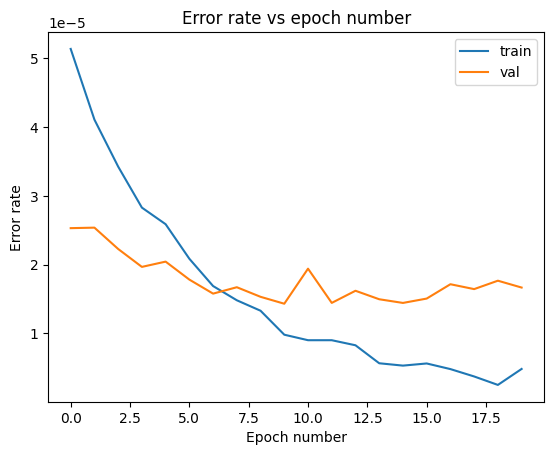

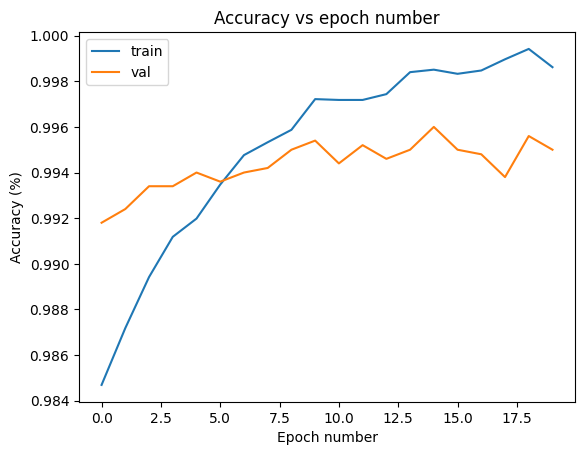

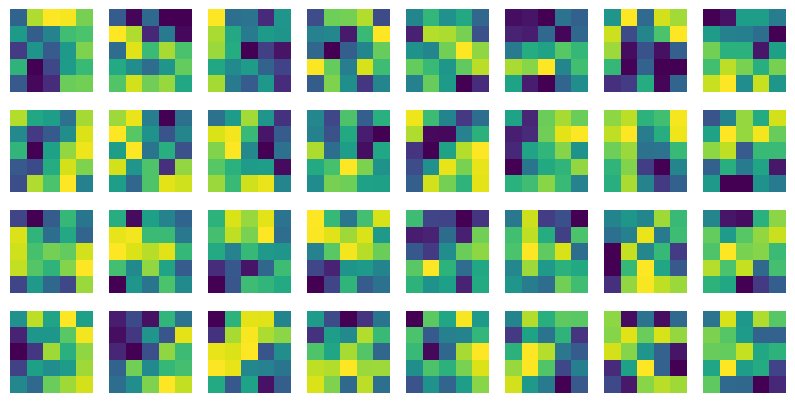

In [81]:
import matplotlib.pyplot as plt
# Load the data
#train, val, test = get_data(data_set=pars.data_set)
#train = (train[0][:10000], train[1][:10000])
#val = (val[0][:1000], val[1][:1000])

# Initialize the network
#net = MNIST_Net(pars).to(pars.device)

# Train the network
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(20):
    t1 = time.time()
    loss_train, acc_train = run_epoch(net, epoch, train, pars, num=pars.numtrain, ttype='train')
    loss_val, acc_val = net_test(net, val, pars, ttype='val')
    t2 = time.time()

    train_loss.append(loss_train)
    train_acc.append(acc_train)
    val_loss.append(loss_val)
    val_acc.append(acc_val)

    print(f'Epoch {epoch}: train_loss={loss_train:.4f}, train_acc={acc_train:.2f}%, val_loss={loss_val:.4f}, val_acc={acc_val:.2f}%')
    print(f'Time elapsed: {t2 - t1:.2f} seconds')

# Plot the error rates
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title('Error rate vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Error rate')
plt.show()

plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.title('Accuracy vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.show()

# Show the learned filters in the first layer
filters = net.conv1.weight.detach().cpu().numpy()
fig, axs = plt.subplots(4, 8, figsize=(10, 5))
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(filters[i, 0])
    axs[i].axis('off')
plt.show()


### (b) Experiment with changing parameters of the network:

(i) Keep the same number of layers and change layer parameters reducing number
of parameters by half in one experiment and doubling the number parameters in
another. Try a few different options. Report the results.

In [82]:
class par1(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=2
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=5
        self.mid_layer=128
        self.use_gpu=False

pars_half=par1()

In [83]:
# use GPU when possible
pars_half.device = device
pars_half.kernel_size=[5,5]
#train,val,test=get_data(data_set=pars_half.data_set)
pars_half.inp_dim=train[0][0].shape


# Initialize the network with the new parameters
net_half = MNIST_Net(pars_half).to(pars_half.device)

# Post it to the gpu if its there.
net.to(pars_half.device)

# Train the network and plot the results
#train,val,test=get_data(data_set=pars_half.data_set)
for epoch in range(pars_half.num_epochs):
    loss_train, acc_train = run_epoch(net_half, epoch, train, pars_half, num=pars_half.numtrain, ttype='train')
    loss_val, acc_val = net_test(net_half, val, pars_half, ttype='val')
    print("Epoch {}: train loss={:.4f}, train acc={:.4f}, val loss={:.4f}, val acc={:.4f}".format(epoch, loss_train, acc_train, loss_val, acc_val))


conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([128, 3136])
fc1.bias torch.Size([128])
fc_final.weight torch.Size([10, 128])
fc_final.bias torch.Size([10])
tot_pars 454922


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0007, Accuracy: 44565/55000 (81.03%)


Validation set: Avg. loss: 0.0001, Accuracy: 4808/5000 (96.16%)

Epoch 0: train loss=0.0007, train acc=0.8103, val loss=0.0001, val acc=0.9616


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52557/55000 (95.56%)


Validation set: Avg. loss: 0.0001, Accuracy: 4915/5000 (98.30%)

Epoch 1: train loss=0.0001, train acc=0.9556, val loss=0.0001, val acc=0.9830


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0000, Accuracy: 54930/55000 (99.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 0: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.62 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0000, Accuracy: 54977/55000 (99.96%)


Validation set: Avg. loss: 0.0000, Accuracy: 4981/5000 (99.62%)

Epoch 1: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.56 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0000, Accuracy: 54987/55000 (99.98%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 2: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 54992/55000 (99.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 3: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.52 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54994/55000 (99.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 4: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54995/55000 (99.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)

Epoch 5: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.53 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54992/55000 (99.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4981/5000 (99.62%)

Epoch 6: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54998/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 7: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54996/55000 (99.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 8: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.56 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54999/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4979/5000 (99.58%)

Epoch 9: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.60 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4979/5000 (99.58%)

Epoch 10: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.58 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 11: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4979/5000 (99.58%)

Epoch 12: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.56 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 13: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 14: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.56 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 15: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.79 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 16: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.92 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 17: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.96 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 18: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.61 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 19: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.60 seconds


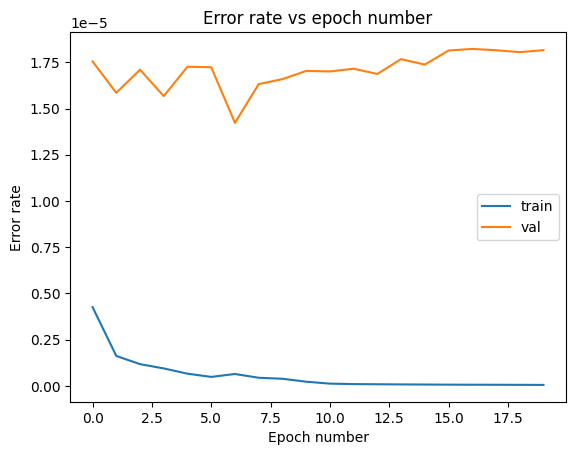

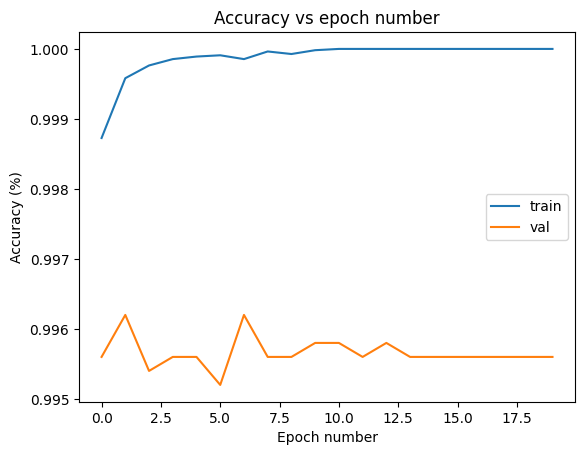

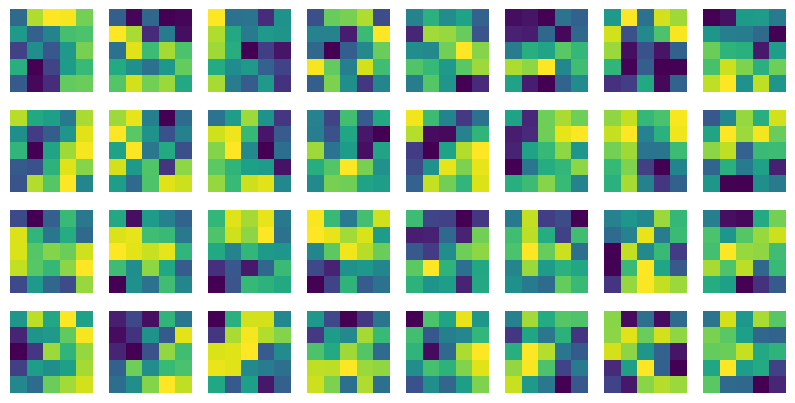

In [84]:
# Train the network
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(20):
    t1 = time.time()
    loss_train, acc_train = run_epoch(net, epoch, train, pars_half, num=pars.numtrain, ttype='train')
    loss_val, acc_val = net_test(net, val, pars_half, ttype='val')
    t2 = time.time()

    train_loss.append(loss_train)
    train_acc.append(acc_train)
    val_loss.append(loss_val)
    val_acc.append(acc_val)

    print(f'Epoch {epoch}: train_loss={loss_train:.4f}, train_acc={acc_train:.2f}%, val_loss={loss_val:.4f}, val_acc={acc_val:.2f}%')
    print(f'Time elapsed: {t2 - t1:.2f} seconds')

# Plot the error rates
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title('Error rate vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Error rate')
plt.show()

plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.title('Accuracy vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.show()

# Show the learned filters in the first layer
filters = net.conv1.weight.detach().cpu().numpy()
fig, axs = plt.subplots(4, 8, figsize=(10, 5))
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(filters[i, 0])
    axs[i].axis('off')
plt.show()

In [85]:
# Double the parameters
class par2(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=2
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=5
        self.mid_layer=512
        self.use_gpu=False

pars_double=par2()

# use GPU when possible
pars_double.device = device
pars_double.kernel_size=[5,5]
#train,val,test=get_data(data_set=pars_double.data_set)
pars_double.inp_dim=train[0][0].shape


# Initialize the network with the new parameters
net_double = MNIST_Net(pars_double).to(pars_double.device)

# Post it to the gpu if its there.
net.to(pars_double.device)




conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([512, 3136])
fc1.bias torch.Size([512])
fc_final.weight torch.Size([10, 512])
fc_final.bias torch.Size([10])
tot_pars 1663370


MNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=[2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop2): Dropout2d(p=0.0, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_final): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc_final): Linear(in_features=256, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 0: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.76 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 1: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.89 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 2: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 3: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 4: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.53 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 5: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 6: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 7: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.53 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 8: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 9: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.59 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 10: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.58 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 11: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 12: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 13: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 14: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 15: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.53 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 16: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)

Epoch 17: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)

Epoch 18: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.60 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 55000/55000 (100.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)

Epoch 19: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 1.57 seconds


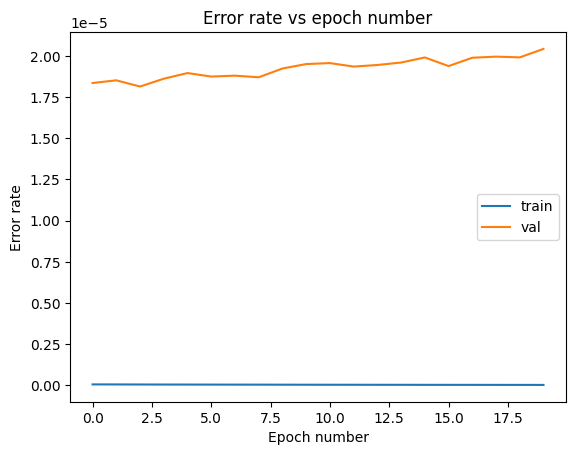

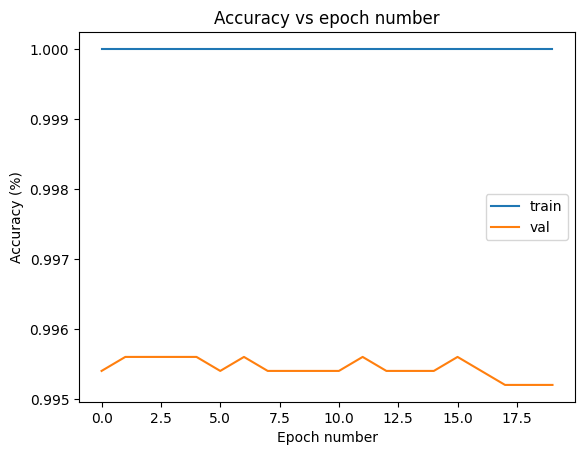

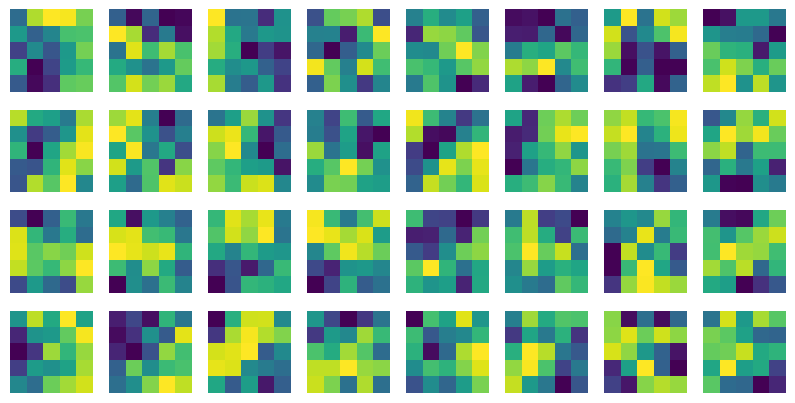

In [86]:
# Train the network
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(20):
    t1 = time.time()
    loss_train, acc_train = run_epoch(net, epoch, train, pars_double, num=pars.numtrain, ttype='train')
    loss_val, acc_val = net_test(net, val, pars_double, ttype='val')
    t2 = time.time()

    train_loss.append(loss_train)
    train_acc.append(acc_train)
    val_loss.append(loss_val)
    val_acc.append(acc_val)

    print(f'Epoch {epoch}: train_loss={loss_train:.4f}, train_acc={acc_train:.2f}%, val_loss={loss_val:.4f}, val_acc={acc_val:.2f}%')
    print(f'Time elapsed: {t2 - t1:.2f} seconds')

# Plot the error rates
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title('Error rate vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Error rate')
plt.show()

plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.title('Accuracy vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.show()

# Show the learned filters in the first layer
filters = net.conv1.weight.detach().cpu().numpy()
fig, axs = plt.subplots(4, 8, figsize=(10, 5))
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(filters[i, 0])
    axs[i].axis('off')
plt.show()


(ii) Design a deeper network with approximately the same number of parameters as
the original network. Report the results.


In [87]:
class MNIST_Net_deeper(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net_deeper, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1 = nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1],padding=ks[1]//2)
        self.pool2 = nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=ks[0],padding=ks[1]//2)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop3 = nn.Dropout2d(pars.dropout)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.drop3(F.relu(self.pool3(self.conv3(x))))

        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

In [89]:
# Initialize the network with the new parameters
net_deeper = MNIST_Net_deeper(pars).to(pars.device)

# Post it to the gpu if its there.
net_deeper.to(pars.device)


input dimension to fc1 1152
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 5, 5])
conv3.bias torch.Size([128])
fc1.weight torch.Size([256, 1152])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 554762


MNIST_Net_deeper(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=[2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=[2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.0, inplace=False)
  (drop_final): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc_final): Linear(in_features=256, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0007, Accuracy: 42504/55000 (77.28%)


Validation set: Avg. loss: 0.0001, Accuracy: 4838/5000 (96.76%)

Epoch 0: train_loss=0.0007, train_acc=0.77%, val_loss=0.0001, val_acc=0.97%
Time elapsed: 2.38 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52951/55000 (96.27%)


Validation set: Avg. loss: 0.0001, Accuracy: 4909/5000 (98.18%)

Epoch 1: train_loss=0.0001, train_acc=0.96%, val_loss=0.0001, val_acc=0.98%
Time elapsed: 2.33 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53754/55000 (97.73%)


Validation set: Avg. loss: 0.0000, Accuracy: 4939/5000 (98.78%)

Epoch 2: train_loss=0.0001, train_acc=0.98%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.33 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 54052/55000 (98.28%)


Validation set: Avg. loss: 0.0000, Accuracy: 4945/5000 (98.90%)

Epoch 3: train_loss=0.0001, train_acc=0.98%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.38 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54213/55000 (98.57%)


Validation set: Avg. loss: 0.0000, Accuracy: 4955/5000 (99.10%)

Epoch 4: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.39 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54380/55000 (98.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4966/5000 (99.32%)

Epoch 5: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.41 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54493/55000 (99.08%)


Validation set: Avg. loss: 0.0000, Accuracy: 4973/5000 (99.46%)

Epoch 6: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.41 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54600/55000 (99.27%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)

Epoch 7: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.43 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54649/55000 (99.36%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)

Epoch 8: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 2.68 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54680/55000 (99.42%)


Validation set: Avg. loss: 0.0000, Accuracy: 4969/5000 (99.38%)

Epoch 9: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 3.03 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54619/55000 (99.31%)


Validation set: Avg. loss: 0.0000, Accuracy: 4973/5000 (99.46%)

Epoch 10: train_loss=0.0000, train_acc=0.99%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.55 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54738/55000 (99.52%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 11: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 2.54 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54838/55000 (99.71%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 12: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 2.45 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54870/55000 (99.76%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)

Epoch 13: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.40 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54858/55000 (99.74%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)

Epoch 14: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 2.51 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54891/55000 (99.80%)


Validation set: Avg. loss: 0.0000, Accuracy: 4966/5000 (99.32%)

Epoch 15: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.57 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54866/55000 (99.76%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)

Epoch 16: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.49 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54934/55000 (99.88%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)

Epoch 17: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 2.35 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54934/55000 (99.88%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)

Epoch 18: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=0.99%
Time elapsed: 2.35 seconds


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54937/55000 (99.89%)


Validation set: Avg. loss: 0.0000, Accuracy: 4979/5000 (99.58%)

Epoch 19: train_loss=0.0000, train_acc=1.00%, val_loss=0.0000, val_acc=1.00%
Time elapsed: 2.34 seconds


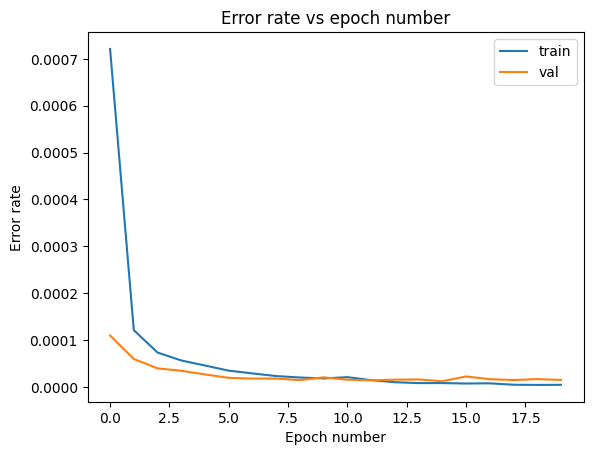

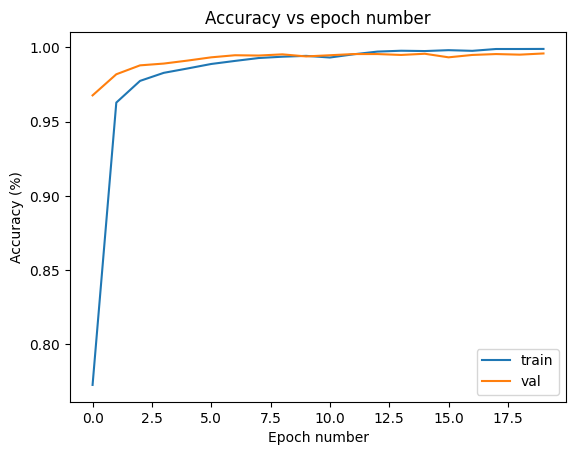

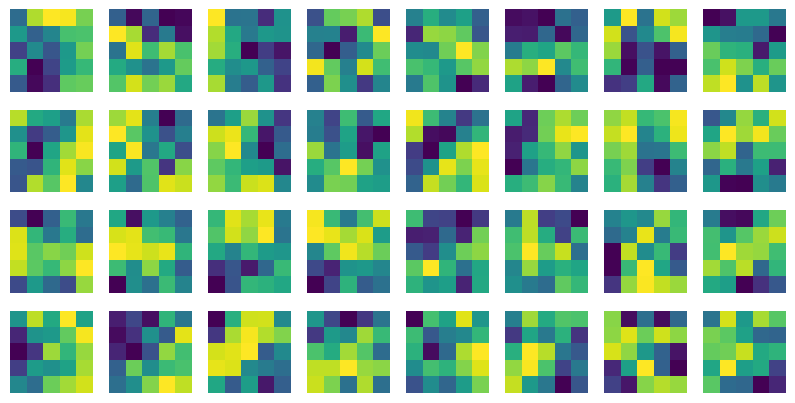

In [90]:
# Train the network
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(20):
    t1 = time.time()
    loss_train, acc_train = run_epoch(net_deeper, epoch, train, pars, num=pars.numtrain, ttype='train')
    loss_val, acc_val = net_test(net_deeper, val, pars, ttype='val')
    t2 = time.time()

    train_loss.append(loss_train)
    train_acc.append(acc_train)
    val_loss.append(loss_val)
    val_acc.append(acc_val)

    print(f'Epoch {epoch}: train_loss={loss_train:.4f}, train_acc={acc_train:.2f}%, val_loss={loss_val:.4f}, val_acc={acc_val:.2f}%')
    print(f'Time elapsed: {t2 - t1:.2f} seconds')

# Plot the error rates
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title('Error rate vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Error rate')
plt.show()

plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.title('Accuracy vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.show()

# Show the learned filters in the first layer
filters = net.conv1.weight.detach().cpu().numpy()
fig, axs = plt.subplots(4, 8, figsize=(10, 5))
axs = axs.ravel()
for i in range(32):
    axs[i].imshow(filters[i, 0])
    axs[i].axis('off')
plt.show()


(iii) Once you pick the best configuration try it on the full training set and report the
result

I have incorporated this question with (b) and we can see that a deeper network is the best configuration

### (c) Handling variability.

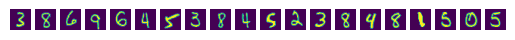

(10000, 1, 28, 28)


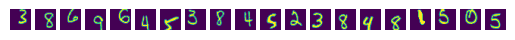

(10000, 1, 28, 28)


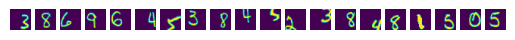

(10000, 1, 28, 28)


(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
   

In [91]:
# Let's just look at the first data entry of test data with 3 different shift value
get_mnist_trans(test[0],shift=2)
get_mnist_trans(test[0],shift=10)
get_mnist_trans(test[0],shift=20)

Using the original trained network to test on this data set. Show the classification rate
as a function of shift.

(70000, 784)


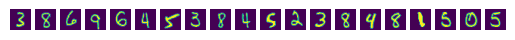

(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Shift: 2, Accuracy: 0.991


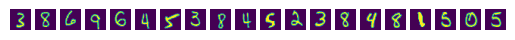

(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9873/10000 (98.73%)

Shift: 4, Accuracy: 0.9873


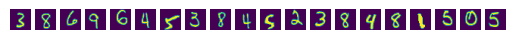

(10000, 1, 28, 28)

Test set: Avg. loss: 0.0003, Accuracy: 9568/10000 (95.68%)

Shift: 6, Accuracy: 0.9568


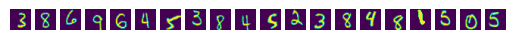

(10000, 1, 28, 28)

Test set: Avg. loss: 0.0011, Accuracy: 8835/10000 (88.35%)

Shift: 8, Accuracy: 0.8835


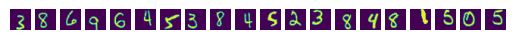

(10000, 1, 28, 28)

Test set: Avg. loss: 0.0032, Accuracy: 7490/10000 (74.90%)

Shift: 10, Accuracy: 0.749


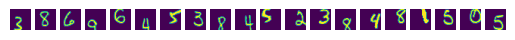

(10000, 1, 28, 28)

Test set: Avg. loss: 0.0109, Accuracy: 4375/10000 (43.75%)

Shift: 15, Accuracy: 0.4375


In [92]:
train,val,test=get_data(data_set=pars.data_set)
shift_values = [2,4,6,8,10,15]
accuracy_values = []

for shift in shift_values:
    # Get the shifted MNIST data
    test_shifted = get_mnist_trans(test[0], shift=shift)
    
    # Compute the accuracy on the shifted data using the original trained network
    _, acc = net_test(net, test_shifted, pars, ttype='test')
    
    accuracy_values.append(acc)
    
    print(f'Shift: {shift}, Accuracy: {acc}')


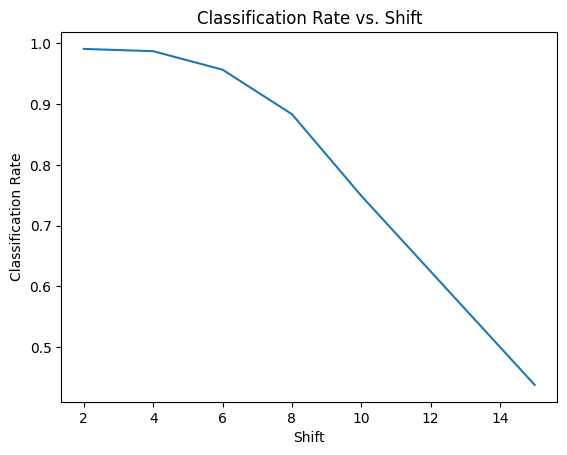

In [93]:
import matplotlib.pyplot as plt

plt.plot(shift_values, accuracy_values)
plt.xlabel('Shift')
plt.ylabel('Classification Rate')
plt.title('Classification Rate vs. Shift')
plt.show()


Try to propose changes to the network architecture so that still training on the original
training set you would perform better on the transformed test set. Perform some experiments
using a transformed validation set and show the final results on the transformed
test set.

## Quesiton 2 Convolutional networks for CIFAR10

#### (a) Read in data

In [94]:
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = get_cifar()

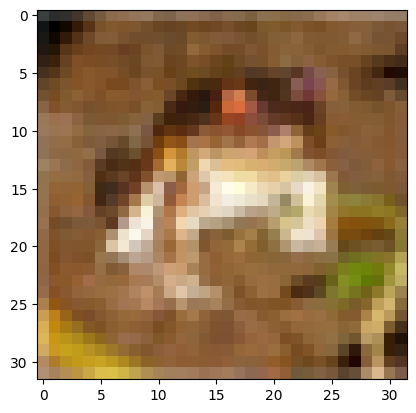

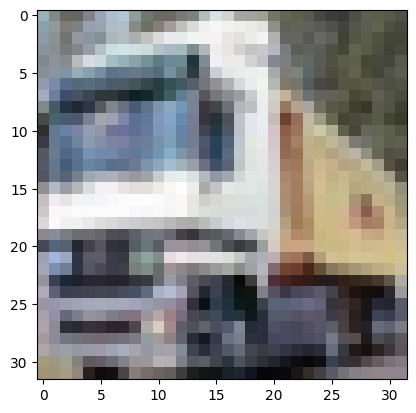

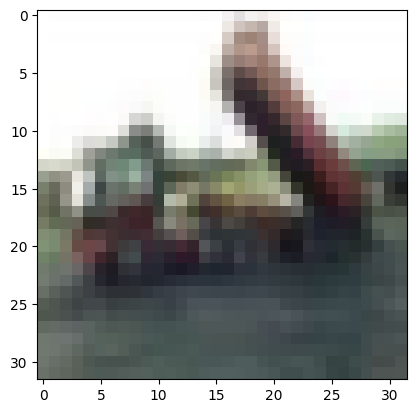

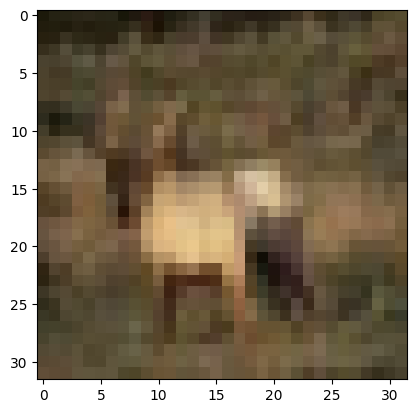

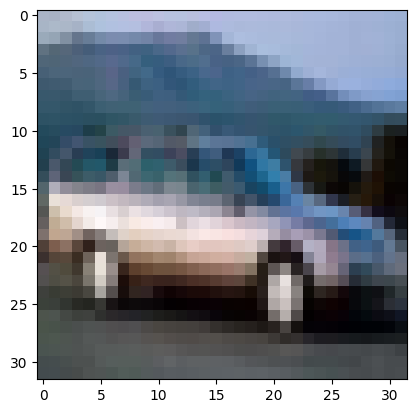

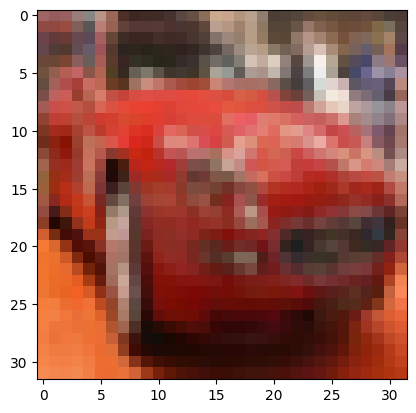

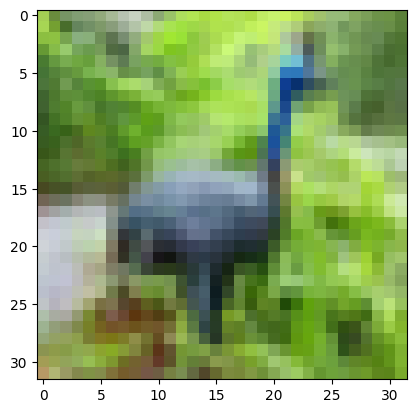

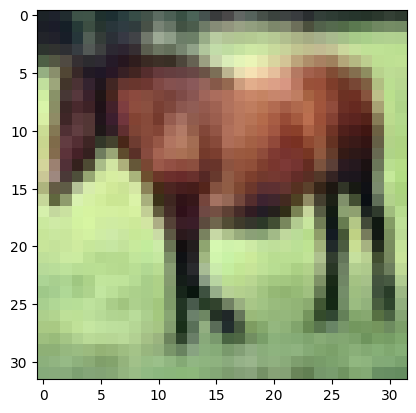

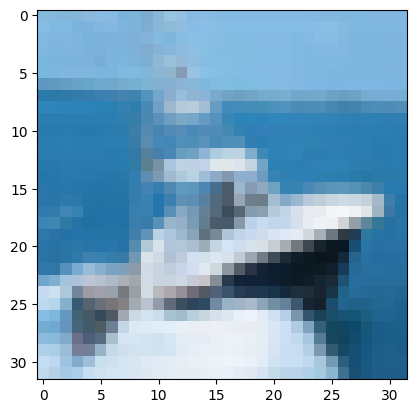

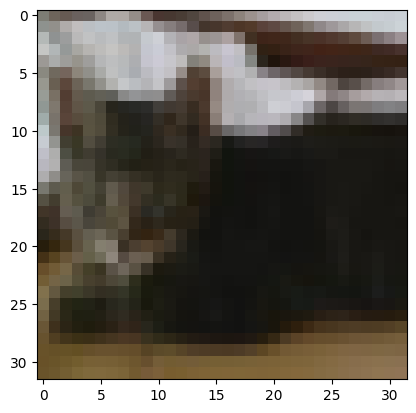

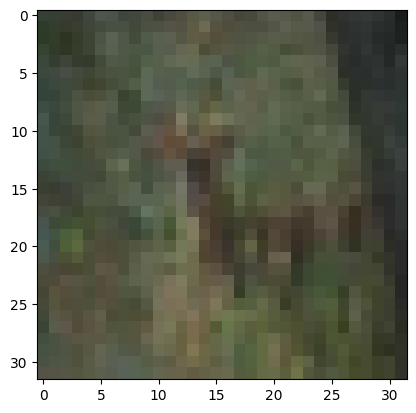

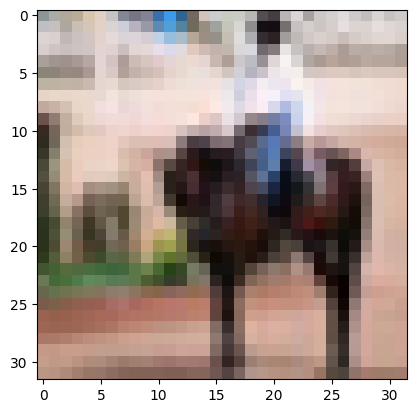

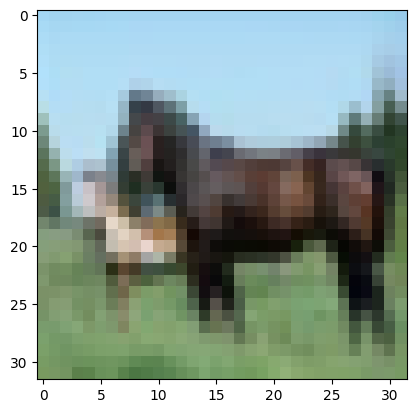

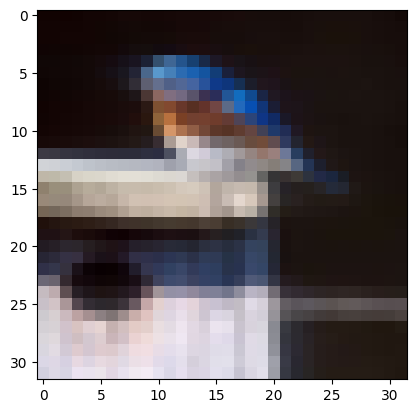

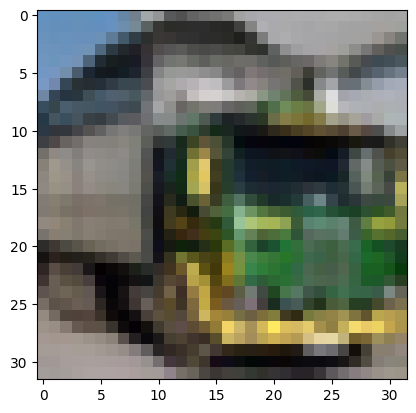

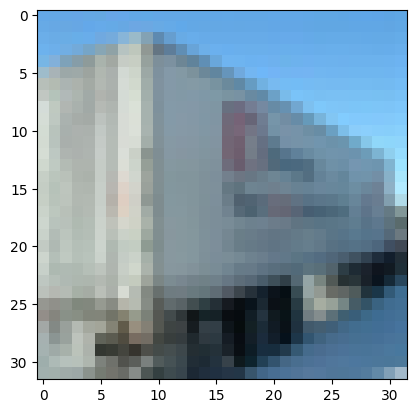

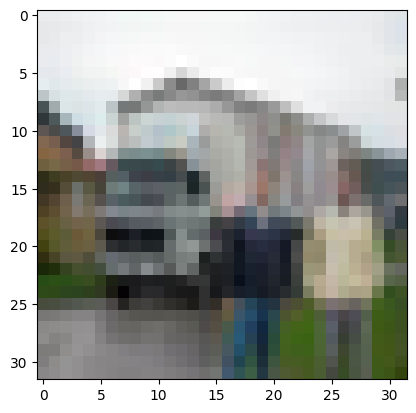

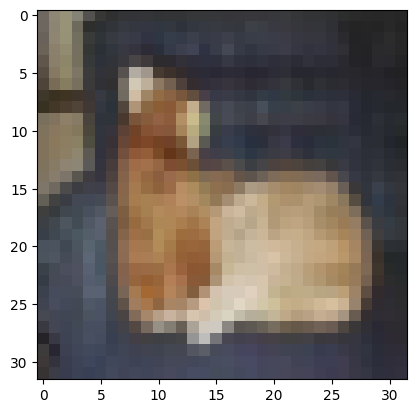

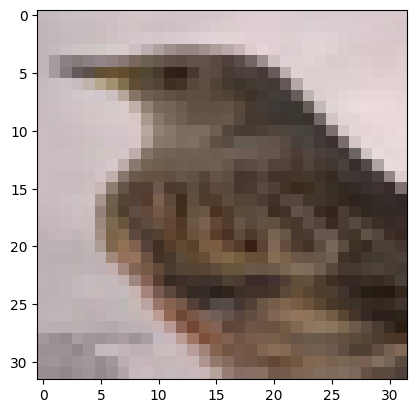

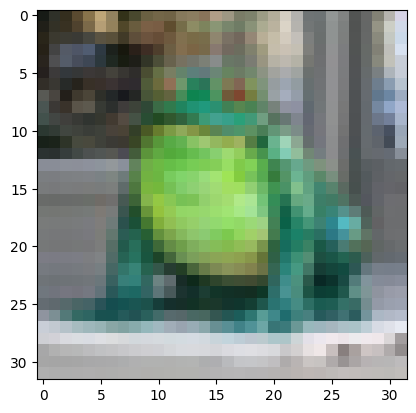

In [95]:
# Transpose the data to the correct format
img_data = train_data.transpose((0, 2, 3, 1))

# Plot the first image in the data

for i in range (20):
  plt.imshow(img_data[i])
  plt.show()


#### (b)
Modify the code to apply the original network to the cifar data. Remember that the
images now have 3 color channels. Again plot training and validation error against
epoch number. Plot the first layer filters.

In [96]:
class CIFAR_Net(nn.Module):
    def __init__(self,pars):
        super(CIFAR_Net, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=ks[0]//2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5,padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):

        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

    def get_first_layer_output(self, x):
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        return x
    
        

In [97]:
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_cifar()
pars.inp_dim=train[0][0].shape
# Initialize the network
net = CIFAR_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])
er_training = []
er_val = []

for i in range(20):
    # Run one epoch of training
    er_training.append(run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train"))
    # Test on validation set.
    er_val.append(net_test(net,val,pars))

conv1 torch.Size([1, 32, 16, 16])
conv2 torch.Size([1, 64, 8, 8])
input dimension to fc1 4096
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 4096])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1105098


  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0019, Accuracy: 14354/45000 (31.90%)


Validation set: Avg. loss: 0.0017, Accuracy: 2028/5000 (40.56%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0015, Accuracy: 20320/45000 (45.16%)


Validation set: Avg. loss: 0.0015, Accuracy: 2411/5000 (48.22%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0014, Accuracy: 23031/45000 (51.18%)


Validation set: Avg. loss: 0.0013, Accuracy: 2700/5000 (54.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0013, Accuracy: 24530/45000 (54.51%)


Validation set: Avg. loss: 0.0013, Accuracy: 2761/5000 (55.22%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0012, Accuracy: 25417/45000 (56.48%)


Validation set: Avg. loss: 0.0012, Accuracy: 2942/5000 (58.84%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0012, Accuracy: 26763/45000 (59.47%)


Validation set: Avg. loss: 0.0011, Accuracy: 2991/5000 (59.82%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0011, Accuracy: 27547/45000 (61.22%)


Validation set: Avg. loss: 0.0011, Accuracy: 3049/5000 (60.98%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0011, Accuracy: 28165/45000 (62.59%)


Validation set: Avg. loss: 0.0011, Accuracy: 3145/5000 (62.90%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0010, Accuracy: 28938/45000 (64.31%)


Validation set: Avg. loss: 0.0010, Accuracy: 3252/5000 (65.04%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0010, Accuracy: 29558/45000 (65.68%)


Validation set: Avg. loss: 0.0010, Accuracy: 3193/5000 (63.86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0010, Accuracy: 29987/45000 (66.64%)


Validation set: Avg. loss: 0.0010, Accuracy: 3290/5000 (65.80%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0009, Accuracy: 30497/45000 (67.77%)


Validation set: Avg. loss: 0.0010, Accuracy: 3359/5000 (67.18%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0009, Accuracy: 30967/45000 (68.82%)


Validation set: Avg. loss: 0.0010, Accuracy: 3380/5000 (67.60%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0008, Accuracy: 31945/45000 (70.99%)


Validation set: Avg. loss: 0.0009, Accuracy: 3442/5000 (68.84%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0008, Accuracy: 32164/45000 (71.48%)


Validation set: Avg. loss: 0.0010, Accuracy: 3367/5000 (67.34%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0008, Accuracy: 32423/45000 (72.05%)


Validation set: Avg. loss: 0.0009, Accuracy: 3464/5000 (69.28%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0008, Accuracy: 32999/45000 (73.33%)


Validation set: Avg. loss: 0.0009, Accuracy: 3489/5000 (69.78%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0008, Accuracy: 33278/45000 (73.95%)


Validation set: Avg. loss: 0.0009, Accuracy: 3462/5000 (69.24%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0007, Accuracy: 33811/45000 (75.14%)


Validation set: Avg. loss: 0.0009, Accuracy: 3465/5000 (69.30%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0007, Accuracy: 34076/45000 (75.72%)


Validation set: Avg. loss: 0.0009, Accuracy: 3508/5000 (70.16%)



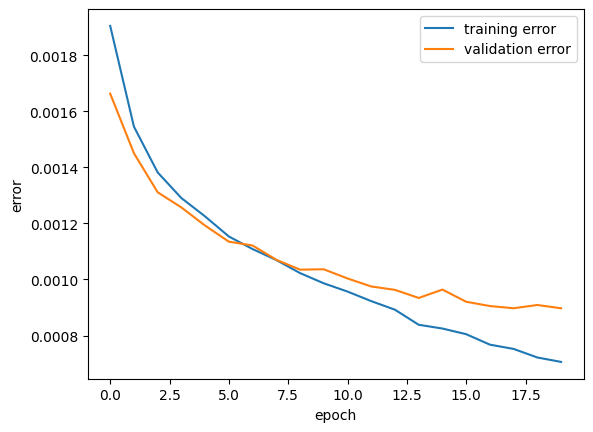

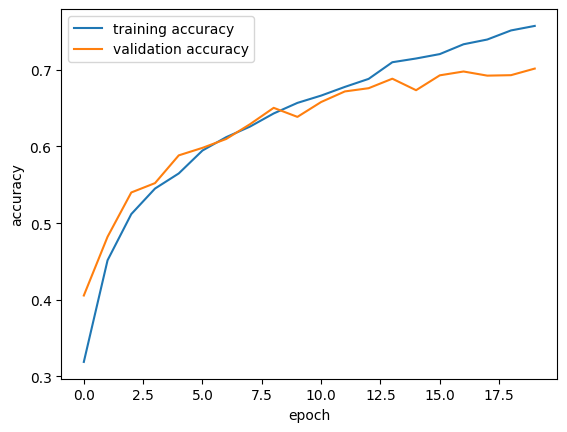

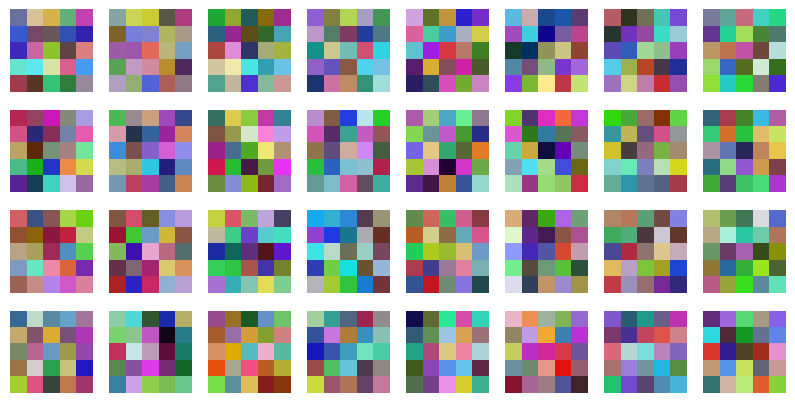

In [98]:
import matplotlib.pyplot as plt
from operator import itemgetter

train_error = [x[0] for x in er_training]
val_error = [x[0] for x in er_val]


train_acc = [x[1] for x in er_training]
val_acc = [x[1] for x in er_val]

# Plot training and validation error against epoch number
plt.plot(train_error, label='training error')
plt.plot(val_error, label='validation error')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

# Plot training and validation accuracy against epoch number
plt.plot(train_acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Get the first layer filters
filters = net.conv1.weight.data.cpu().numpy()

# Normalize the filters to [0,1]
filters = (filters - np.min(filters)) / (np.max(filters) - np.min(filters))

# Plot the filters as a grid of images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10,5))
for i,ax in enumerate(axes.flat):
    if i<filters.shape[0]:
        ax.imshow(filters[i].transpose(1,2,0))
        ax.axis('off')
plt.show()

#### (c) Try to define a deeper network and see if you get an improvement.

In [75]:
class CIFAR_Net_deeper(nn.Module):
    def __init__(self,pars):
        super(CIFAR_Net_deeper, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=ks[0]//2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5,padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=ks[0],padding=ks[1]//2)	
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)	
        self.drop3 = nn.Dropout2d(pars.dropout)
        self.drop_final=nn.Dropout(pars.dropout)
        	
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):

        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        #x = F.relu(self.pool2(self.conv2(x)))	
        #x = self.drop3(F.relu(self.pool3(self.conv3(x))))


        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        x = self.drop3(F.relu(self.pool3(self.conv3(x))))

        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

    def get_first_layer_output(self, x):
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        return x
    
        

In [76]:
train,val,test=get_cifar()

# Initialize the network
net_cifar_deep = CIFAR_Net_deeper(pars).to(pars.device)
# Post it to the gpu if its there.
net_cifar_deep.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])
er_training = []
er_val = []

for i in range(20):
    # Run one epoch of training
    er_training.append(run_epoch(net_cifar_deep,i,train, pars, num=pars.numtrain, ttype="train"))
    # Test on validation set.
    er_val.append(net_test(net_cifar_deep,val,pars))

conv1 torch.Size([1, 32, 16, 16])
conv2 torch.Size([1, 64, 8, 8])
input dimension to fc1 2048
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 5, 5])
conv3.bias torch.Size([128])
fc1.weight torch.Size([256, 2048])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 785738


  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0020, Accuracy: 11941/45000 (26.54%)


Validation set: Avg. loss: 0.0018, Accuracy: 1725/5000 (34.50%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0016, Accuracy: 18797/45000 (41.77%)


Validation set: Avg. loss: 0.0015, Accuracy: 2320/5000 (46.40%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0014, Accuracy: 21481/45000 (47.74%)


Validation set: Avg. loss: 0.0014, Accuracy: 2501/5000 (50.02%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0014, Accuracy: 23245/45000 (51.66%)


Validation set: Avg. loss: 0.0013, Accuracy: 2675/5000 (53.50%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0013, Accuracy: 24590/45000 (54.64%)


Validation set: Avg. loss: 0.0012, Accuracy: 2819/5000 (56.38%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0012, Accuracy: 25918/45000 (57.60%)


Validation set: Avg. loss: 0.0012, Accuracy: 2951/5000 (59.02%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0011, Accuracy: 26907/45000 (59.79%)


Validation set: Avg. loss: 0.0011, Accuracy: 3041/5000 (60.82%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0011, Accuracy: 27840/45000 (61.87%)


Validation set: Avg. loss: 0.0011, Accuracy: 3112/5000 (62.24%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0010, Accuracy: 28774/45000 (63.94%)


Validation set: Avg. loss: 0.0010, Accuracy: 3216/5000 (64.32%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0010, Accuracy: 29711/45000 (66.02%)


Validation set: Avg. loss: 0.0010, Accuracy: 3230/5000 (64.60%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0009, Accuracy: 30323/45000 (67.38%)


Validation set: Avg. loss: 0.0010, Accuracy: 3297/5000 (65.94%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0009, Accuracy: 30755/45000 (68.34%)


Validation set: Avg. loss: 0.0009, Accuracy: 3373/5000 (67.46%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0009, Accuracy: 31553/45000 (70.12%)


Validation set: Avg. loss: 0.0009, Accuracy: 3382/5000 (67.64%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0008, Accuracy: 32012/45000 (71.14%)


Validation set: Avg. loss: 0.0009, Accuracy: 3415/5000 (68.30%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0008, Accuracy: 32587/45000 (72.42%)


Validation set: Avg. loss: 0.0009, Accuracy: 3398/5000 (67.96%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0008, Accuracy: 33139/45000 (73.64%)


Validation set: Avg. loss: 0.0009, Accuracy: 3491/5000 (69.82%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0007, Accuracy: 33527/45000 (74.50%)


Validation set: Avg. loss: 0.0008, Accuracy: 3546/5000 (70.92%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0007, Accuracy: 34233/45000 (76.07%)


Validation set: Avg. loss: 0.0008, Accuracy: 3514/5000 (70.28%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0007, Accuracy: 34484/45000 (76.63%)


Validation set: Avg. loss: 0.0009, Accuracy: 3484/5000 (69.68%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0006, Accuracy: 35215/45000 (78.26%)


Validation set: Avg. loss: 0.0009, Accuracy: 3545/5000 (70.90%)



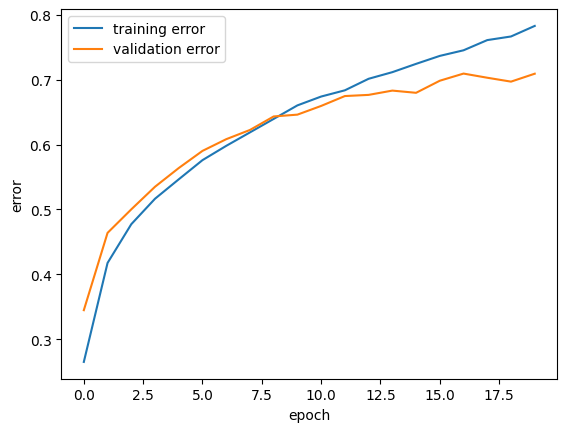

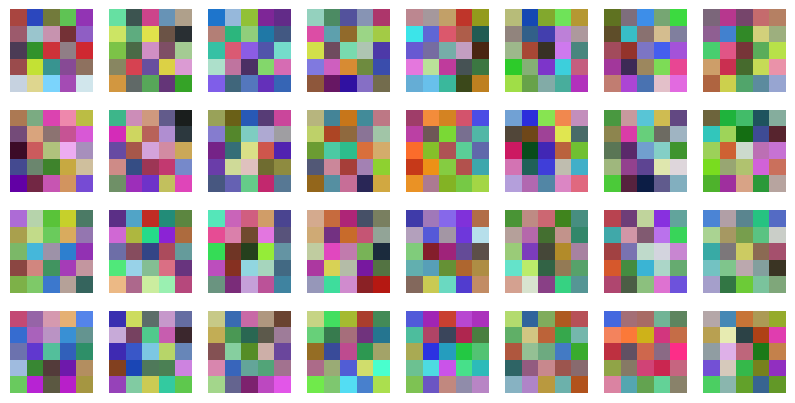

In [77]:
import matplotlib.pyplot as plt
from operator import itemgetter

train_error = [x[1] for x in er_training]
val_error = [x[1] for x in er_val]

# Plot training and validation error against epoch number
plt.plot(train_error, label='training error')
plt.plot(val_error, label='validation error')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

# Get the first layer filters
filters = net.conv1.weight.data.cpu().numpy()

# Normalize the filters to [0,1]
filters = (filters - np.min(filters)) / (np.max(filters) - np.min(filters))

# Plot the filters as a grid of images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10,5))
for i,ax in enumerate(axes.flat):
    if i<filters.shape[0]:
        ax.imshow(filters[i].transpose(1,2,0))
        ax.axis('off')
plt.show()

#### (d) Handling variability.

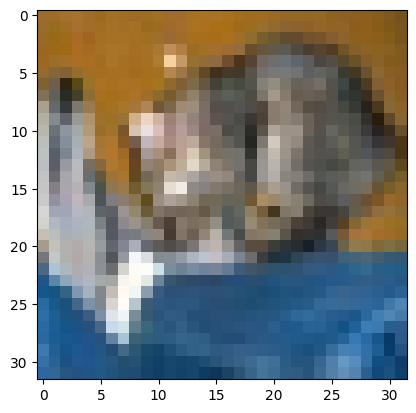

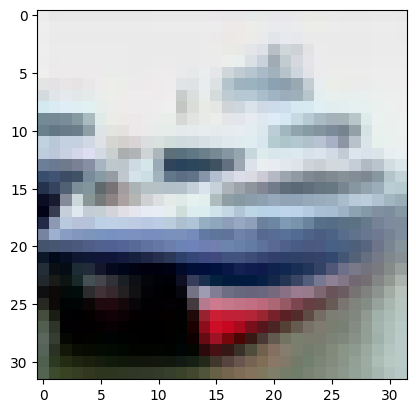

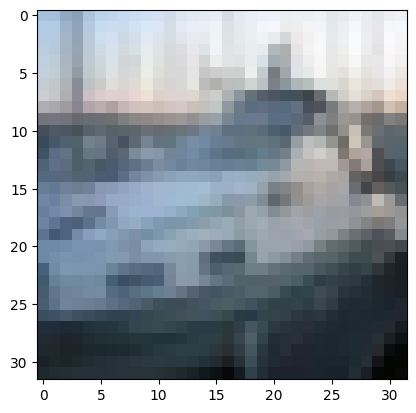

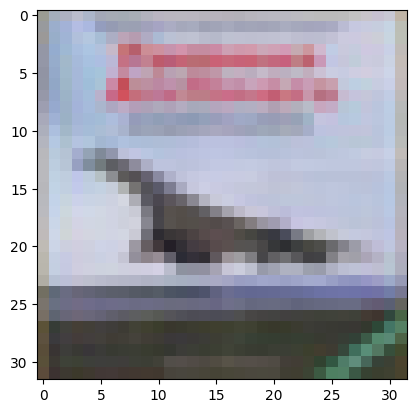

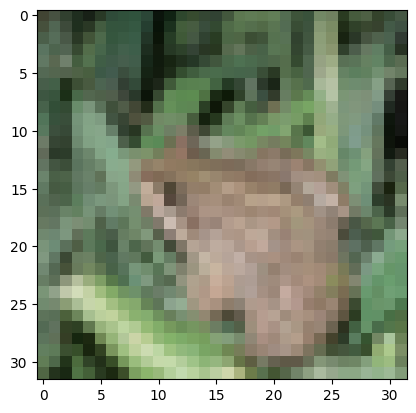

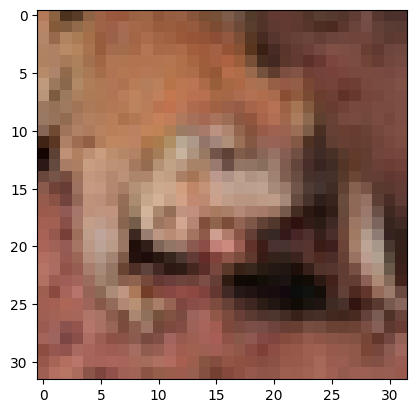

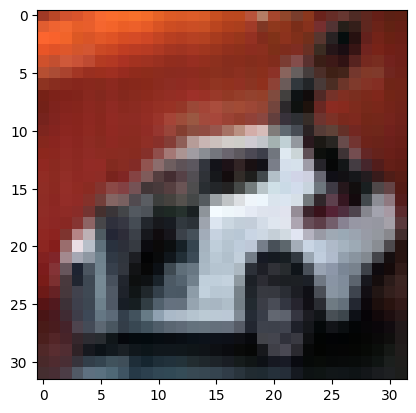

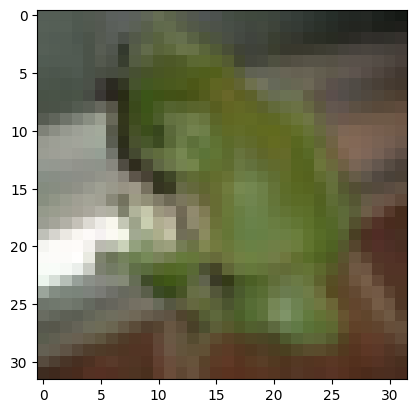

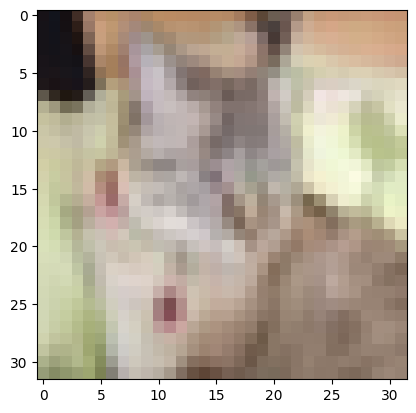

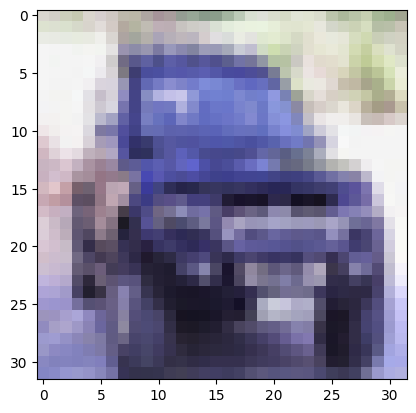

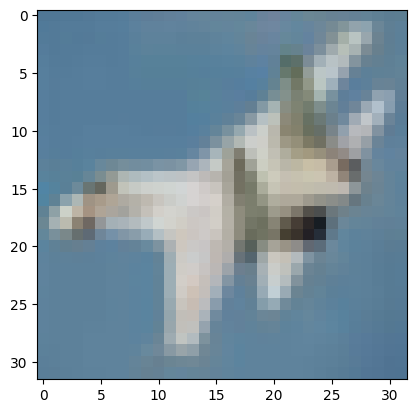

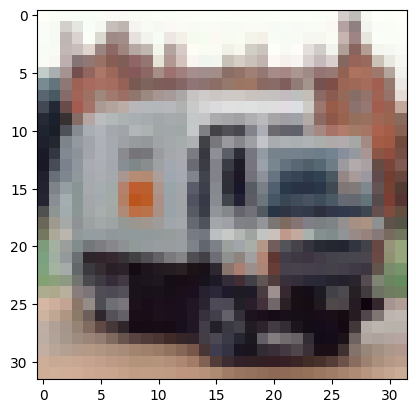

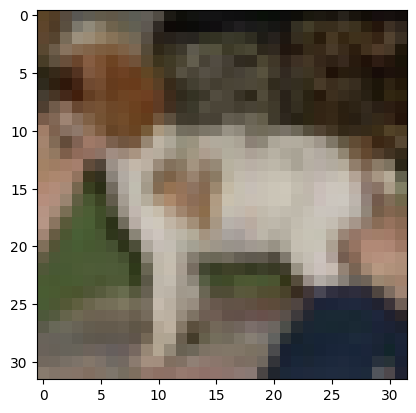

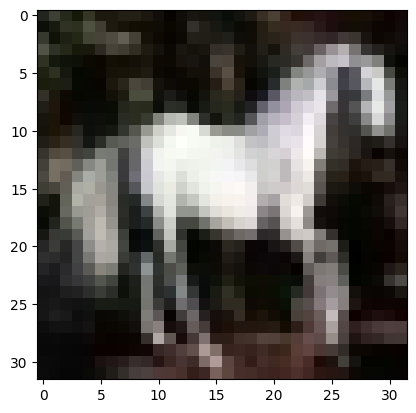

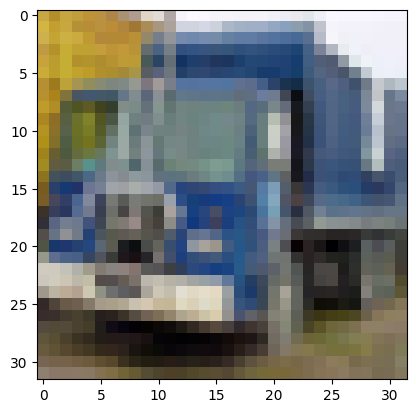

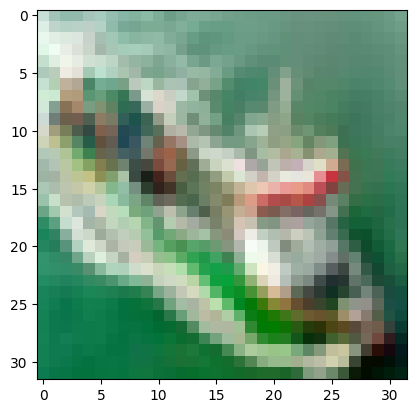

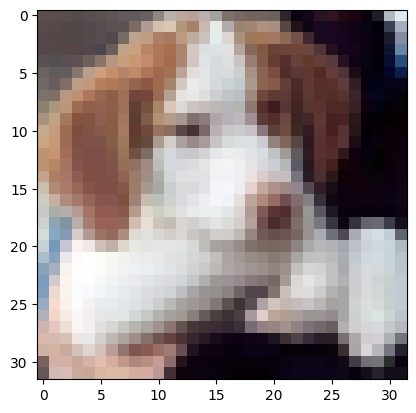

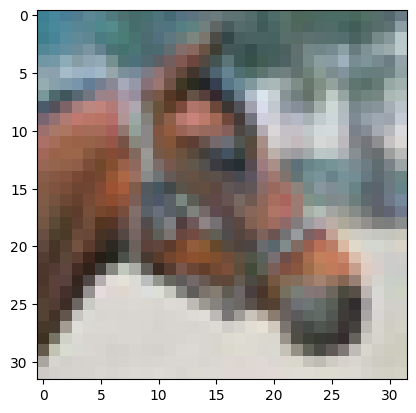

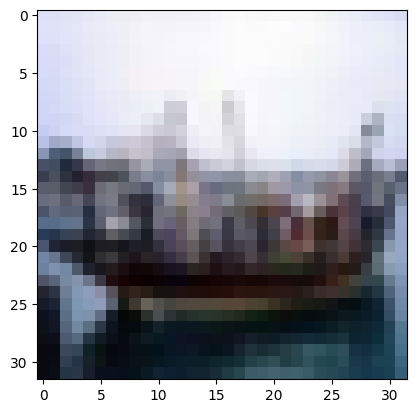

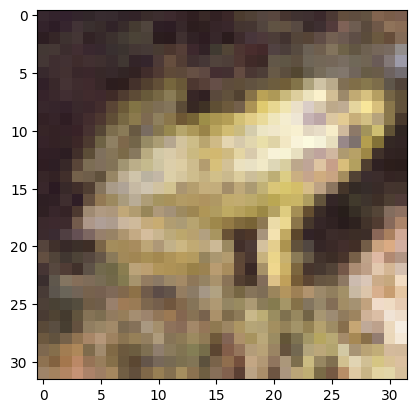

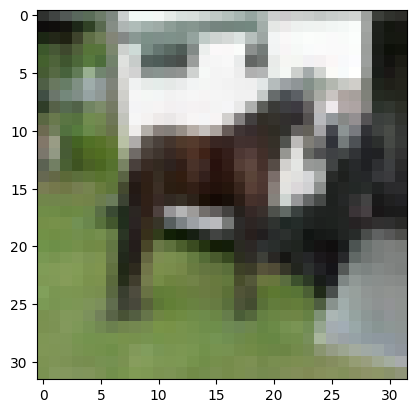

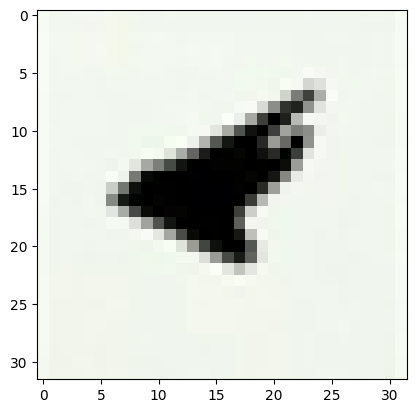

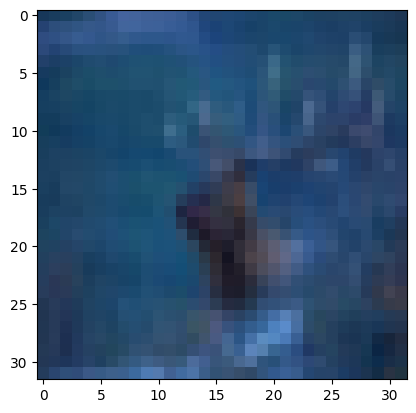

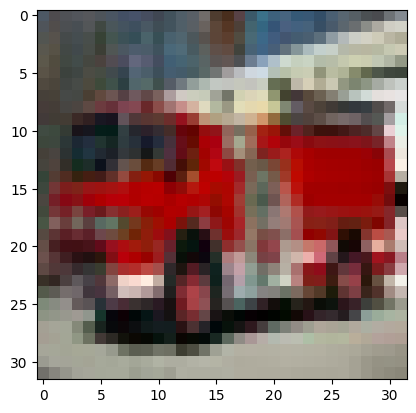

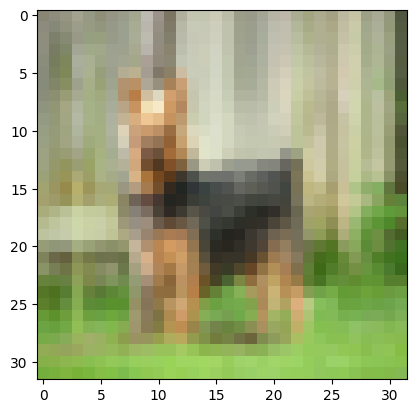

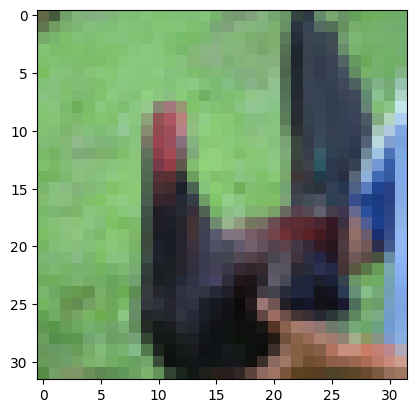

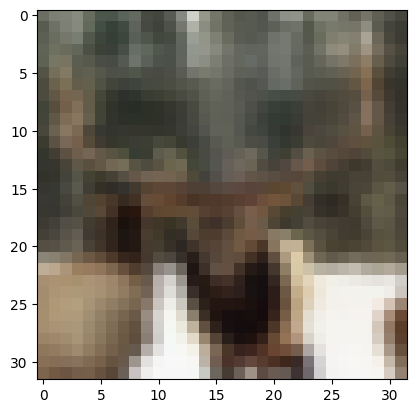

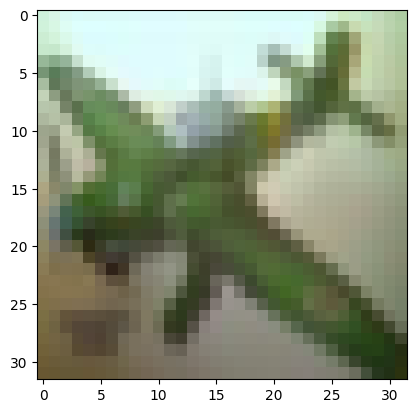

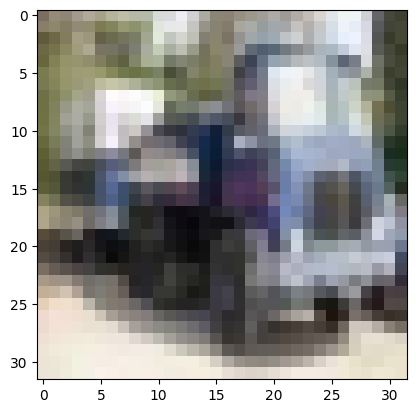

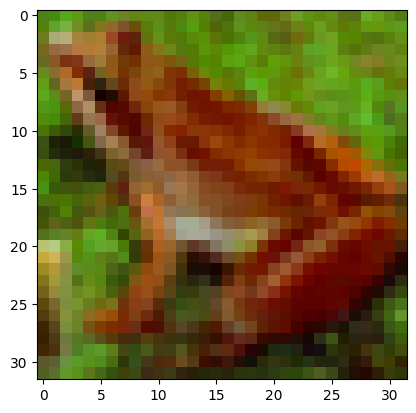

In [99]:
import random
from skimage import color

test_data = test[0]

# Loop over all test images
for i in range(len(test_data)):
    # Convert to HSV
    hsv_img = color.rgb2hsv(test_data[i].transpose(1, 2, 0))

    # Multiply saturation by a random value between 0.75 and 1.25
    hsv_img[..., 1] *= random.uniform(0.75, 1.25)

    # Convert back to RGB and transpose to match original shape
    rgb_img = color.hsv2rgb(hsv_img).transpose(2, 0, 1)
    test_data[i] = rgb_img

# Since there are too many data, let's just plot the first 30 of the transformed test_data
for i in range (30):
  img = np.transpose(test_data[i], (1, 2, 0))
  plt.imshow(img)
  plt.show()
